In [1546]:
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'none'
import numpy as np
import cv2
import math
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter1d

In [1547]:
def display_images(imgs, titles, width=5):
    n = len(imgs)
    rows = math.ceil(n / 3)
    cols = n // rows
    h, w = imgs[0].shape[:2]
    fig, axs = plt.subplots(rows, cols, figsize=(width * cols, width * h / w * rows))
    axs = axs.flatten()
    for i in range(rows * cols):
        if i < n:
            img = imgs[i]
            axs[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
            axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


def to_float(img):
    img = img.astype(np.float64)
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def to_uint8(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return np.round(norm * 255).astype(np.uint8)

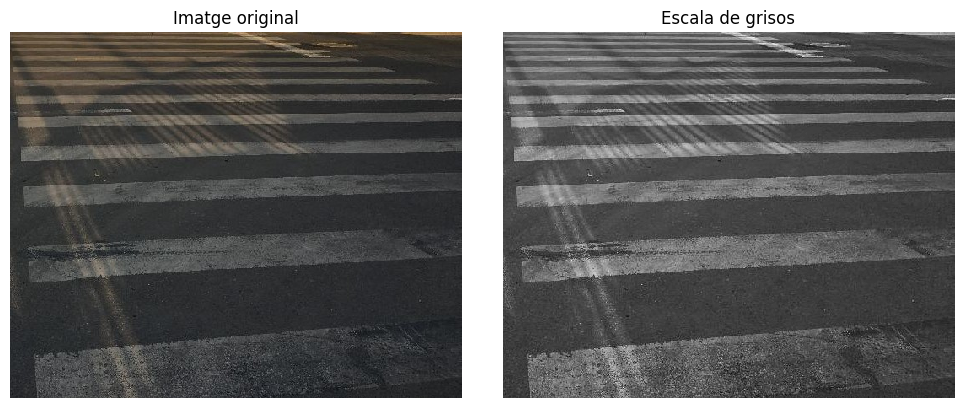

In [1548]:
path = "../data/examples_cropped/heon_IMG_0534.JPG" # Ombres
# path = "../data/examples_cropped/heon_IMG_0520.JPG" # Il·luminació horrible
# path = "../data/examples_cropped/sam_IMG_6482.jpg" # Neu

img = plt.imread(path)
height, width, channels = img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

display_images([img, gray], ['Imatge original', 'Escala de grisos'])

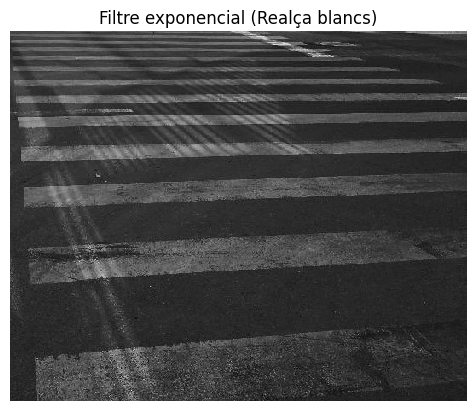

In [1549]:
exp = np.pow(np.e, to_float(gray))
exp = to_uint8(exp)

plt.imshow(exp, cmap='gray')
plt.title('Filtre exponencial (Realça blancs)')
plt.axis('off')
plt.show()

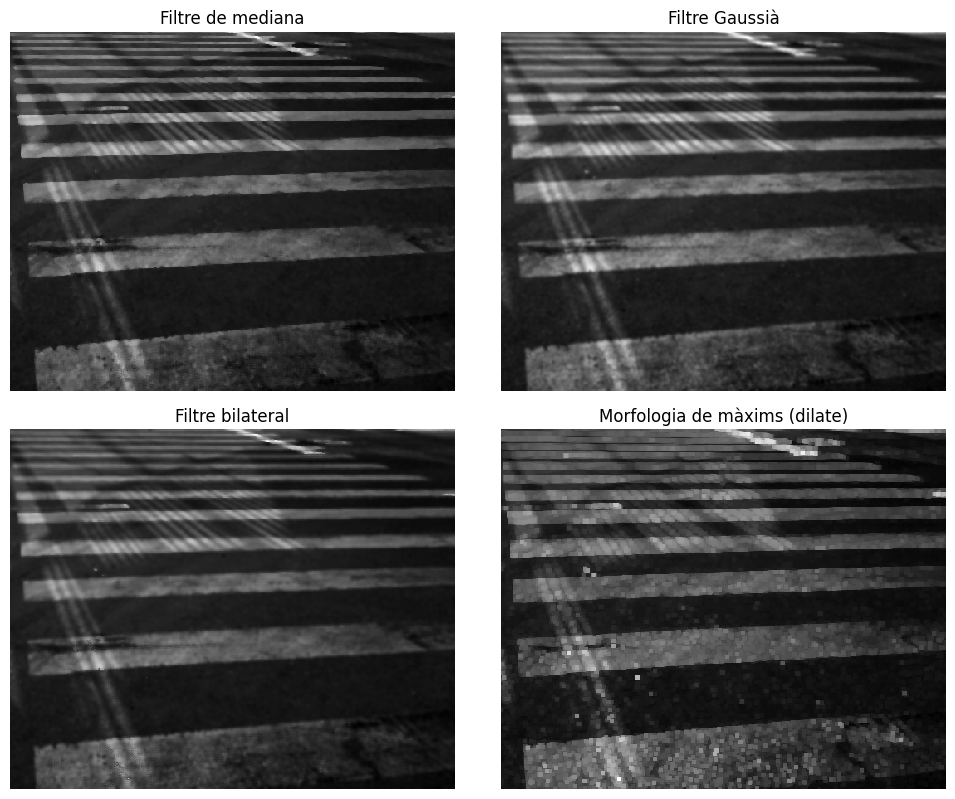

In [1550]:
src = exp

med = cv2.medianBlur(src, 5)

sigma = 1.5
ksize = round(6 * sigma + 1)
ksize = ksize + 1 - (ksize % 2)
blur = cv2.GaussianBlur(src, (ksize, ksize), sigma)

bilat = cv2.bilateralFilter(src, d=6, sigmaColor=75, sigmaSpace=75)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
max = cv2.morphologyEx(src, cv2.MORPH_DILATE, kernel)

display_images([med, blur, bilat, max], ['Filtre de mediana', 'Filtre Gaussià', 'Filtre bilateral', 'Morfologia de màxims (dilate)'])

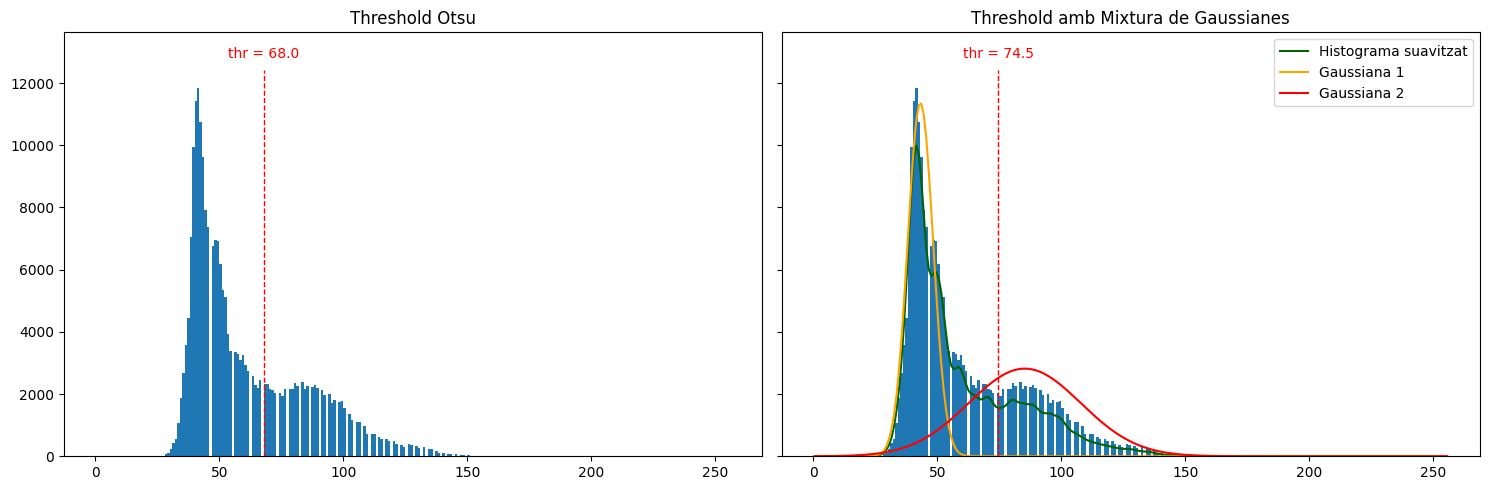

In [1551]:
src = med

# Otsu
hist, bins = np.histogram(src, bins=256, range=(0, 256))
thr1, bw = cv2.threshold(src, 0, 256, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Mixtura de Gaussianes
sample = cv2.resize(src, (14, 14), interpolation=cv2.INTER_CUBIC).reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(sample)
means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()
m1, m2 = np.sort(means)

hist_smooth = gaussian_filter1d(hist, sigma=2)
bin_centers = (bins[:-1] + bins[1:]) / 2

mask = (bin_centers > m1) & (bin_centers < m2)
thr2 = bin_centers[mask][np.argmin(hist_smooth[mask])]

pdf1 = weights[0] * np.exp(-0.5 * ((bin_centers - means[0])**2) / covs[0]) / np.sqrt(2 * np.pi * covs[0])
pdf2 = weights[1] * np.exp(-0.5 * ((bin_centers - means[1])**2) / covs[1]) / np.sqrt(2 * np.pi * covs[1])
pdf_scale = np.max(hist) / np.max(pdf1 + pdf2)

# Gràfica
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

axs[0].bar((bins[1:] + bins[:-1]) / 2, hist, width=1)
axs[0].axvline(thr1, color='red', linestyle='--', linewidth=1, ymax=0.91)
axs[0].text(float(thr1), np.max(hist) * 1.08, f'thr = {thr1:.1f}', color='red', ha='center')
axs[0].set_ylim(0, np.max(hist) * 1.15)
axs[0].set_title('Threshold Otsu')

axs[1].bar(bin_centers, hist, width=1)
axs[1].plot(bin_centers, hist_smooth, color='darkgreen', label='Histograma suavitzat')
axs[1].plot(bin_centers, pdf1 * pdf_scale, color='orange', label='Gaussiana 1')
axs[1].plot(bin_centers, pdf2 * pdf_scale, color='red', label='Gaussiana 2')
axs[1].axvline(thr2, color='red', linestyle='--', linewidth=1, ymax=0.91)
axs[1].text(float(thr2), np.max(hist) * 1.08, f'thr = {thr2:.1f}', color='red', ha='center')
axs[1].set_ylim(0, np.max(hist) * 1.15)
axs[1].set_title('Threshold amb Mixtura de Gaussianes')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


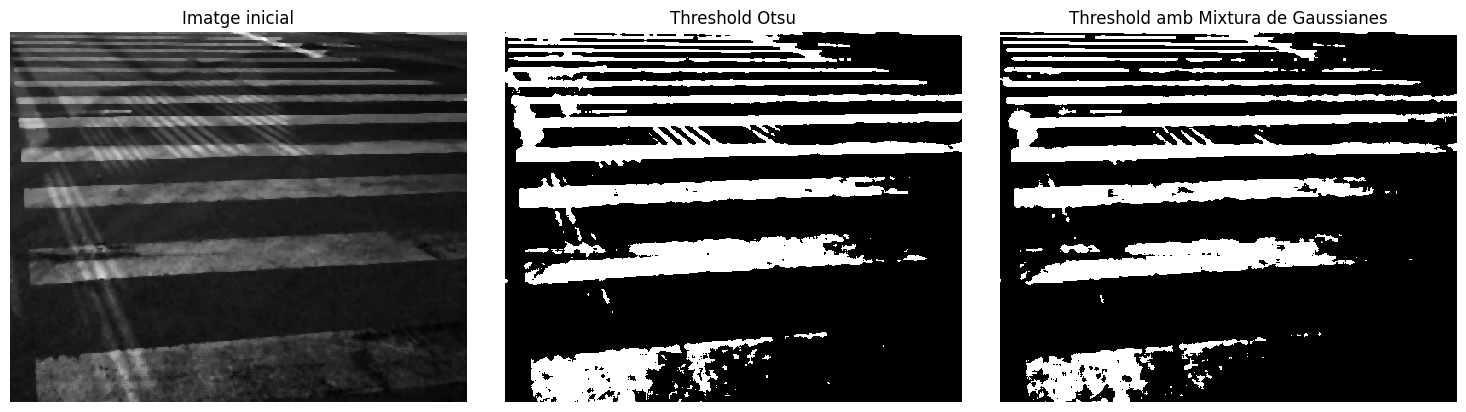

In [1552]:
bw1 = src > thr1
bw2 = src > thr2

display_images([src, bw1, bw2], ['Imatge inicial', 'Threshold Otsu', 'Threshold amb Mixtura de Gaussianes'])

In [1553]:
# bw = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 2001, 2)

# plt.imshow(bw, cmap="grey")
# plt.axis('off')
# plt.show()

In [1554]:
# src = med

# src_blur = cv2.GaussianBlur(to_uint8(src), (5, 5), 0)
# src_bgr = cv2.cvtColor(src_blur, cv2.COLOR_GRAY2BGR)
# seg = cv2.pyrMeanShiftFiltering(src_bgr, sp=20, sr=30)
# seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
# bin = seg > thr

# display_images([src, seg, bin], ['Imatge original', 'Filtre de mitjana desplaçada', 'Imatge binaritzada'])

In [1555]:
# src = med

# # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# n = 60
# kernel = cv2.resize(bw, (n, n), interpolation=cv2.INTER_NEAREST)
# background = cv2.morphologyEx(med, cv2.MORPH_OPEN, kernel)
# top_hat = src - background

# display_images([src, background, top_hat], ['Imatge base', 'Background', 'Top-hat'])

# plt.imshow(kernel, cmap='gray')
# plt.title('Kernel')
# plt.axis('off')
# plt.show()

In [1556]:
# # kernel = np.ones((1, 1), np.uint8)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))


# morph = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel)
# morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# axes[0].imshow(thr, cmap="gray")
# axes[0].axis('off')

# axes[1].imshow(morph, cmap="gray")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

In [1557]:
# feature_map = np.abs(feature_map)
# feature_map = 255 * (feature_map - np.min(feature_map))/(np.max(feature_map)-np.min(feature_map))
# feature_map = feature_map.astype(np.uint8)
# plt.imshow(feature_map, cmap="gray")
# plt.axis('off')

In [1558]:
# edges = cv2.Canny(eq, threshold1=50, threshold2=100, apertureSize=3)
# plt.imshow(edges, cmap="grey")
# plt.axis('off')
# plt.show()

In [1559]:
# # imagen_suavizada = cv2.GaussianBlur(eq, (5, 5), 0)
# bordes_log = cv2.Laplacian(morph, cv2.CV_64F)
# bordes_log = np.uint8(np.absolute(bordes_log))

# # cv2.imshow('Bordes LoG', bordes_log)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

In [1560]:
# lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=150)

# img_lines = img.copy()

# if lines is not None:
#     for line in lines:
#         rho, theta = line[0]
#         a, b = np.cos(theta), np.sin(theta)
#         x0, y0 = a*rho, b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*( a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*( a))
#         cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# plt.imshow(img_lines)
# plt.axis('off')
# plt.show()


In [1561]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=150, minLineLength=50, maxLineGap=100)

# img_lines = img.copy()

# if lines is not None:
#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# plt.imshow(img_lines)
# plt.axis('off')
# plt.axis('off')
# plt.show()


In [1562]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.transform import hough_line
# from skimage import color, feature

# img = cv2.imread(path)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# edges_skimage = feature.canny(gray)

# hspace, angles, dists = hough_line(edges_skimage)

# plt.figure(figsize=(8, 6))
# plt.imshow(hspace, extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), dists[-1], dists[0]],
#            cmap='Reds', aspect='auto')
# plt.title('Acumulador Hough (skimage)')
# plt.xlabel('Ángulo (grados)')
# plt.ylabel('Distancia (píxeles)')
# plt.show()

In [1563]:
# # Calcular imagen integral
# integral = cv2.integral(gray)

# # Tamaño de la ventana
# w, h = 8, 8
# half_h = h // 2

# # Crear un mapa para guardar los valores de la feature
# feature_map = np.zeros((gray.shape[0] - h, gray.shape[1] - w))

# # Función para suma de rectángulo
# def rect_sum(ii, x, y, w, h):
#     A = ii[y][x]
#     B = ii[y][x + w]
#     C = ii[y + h][x]
#     D = ii[y + h][x + w]
#     return D - B - C + A

# # Escanear con ventana deslizante
# for y in range(0, gray.shape[0] - h):
#     for x in range(0, gray.shape[1] - w):
#         top = rect_sum(integral, x, y, w, half_h)
#         bottom = rect_sum(integral, x, y + half_h, w, half_h)
#         feature_value = top - bottom
#         feature_map[y, x] = feature_value

# # Visualizar el mapa de valores
# plt.figure(figsize=(10, 6))
# plt.imshow(feature_map, cmap='seismic', interpolation='nearest')
# plt.colorbar(label='Haar-like Feature Value')
# plt.title('Mapa de características Haar-like (dos rectángulos horizontales)')
# plt.axis('off')
# plt.show()